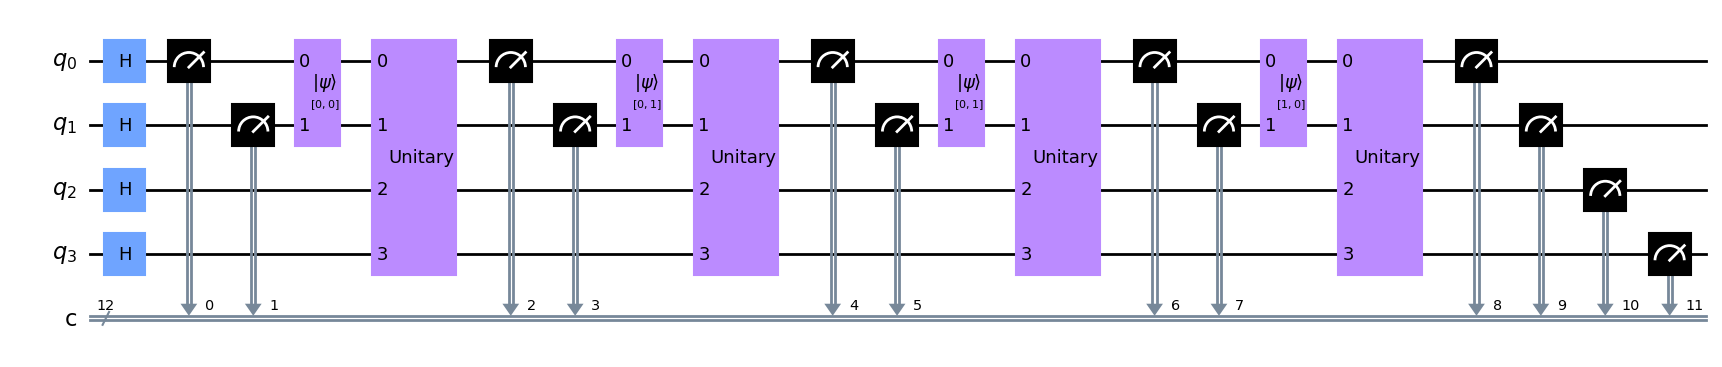

In [37]:
import numpy as np
from qiskit import Aer
from qiskit.quantum_info import random_unitary
from qreservoirpy import QReservoir

encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
}
SHOTS = 50000


class RandomUnitary(QReservoir):
    def __init__(self, n_qubits, memory=np.inf) -> None:
        super().__init__(n_qubits, memory=memory)
        self.operator = random_unitary(2 ** n_qubits)
    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep):
        circuit.measure([0, 1])
        circuit.initialize(encoder[timestep], [0, 1])
        circuit.append(self.operator, circuit.qubits)

    def after(self, circuit):
        circuit.measure_all()

    def analyze_fcn(self, meas):
        meas = meas[-6:]
        return meas.reshape((1, -1))



res = RandomUnitary(n_qubits=4, memory=6)

timestep = [0, 1, 1, 2, 0, 1, 1, 3]
timeseries = timestep * 10

res.circuit([0, 1, 1, 2], merge_registers=True).draw('mpl')



In [38]:
states = res.run_incrementally(timeseries, shots=SHOTS)

Analyzing... : 100%|██████████| 80/80 [03:50<00:00,  2.88s/it]  


In [39]:
warmup = 0.1
warmup_len = int(len(states) * warmup)
xstates = states[:-1][warmup_len:]
target = timeseries[1:][warmup_len:]


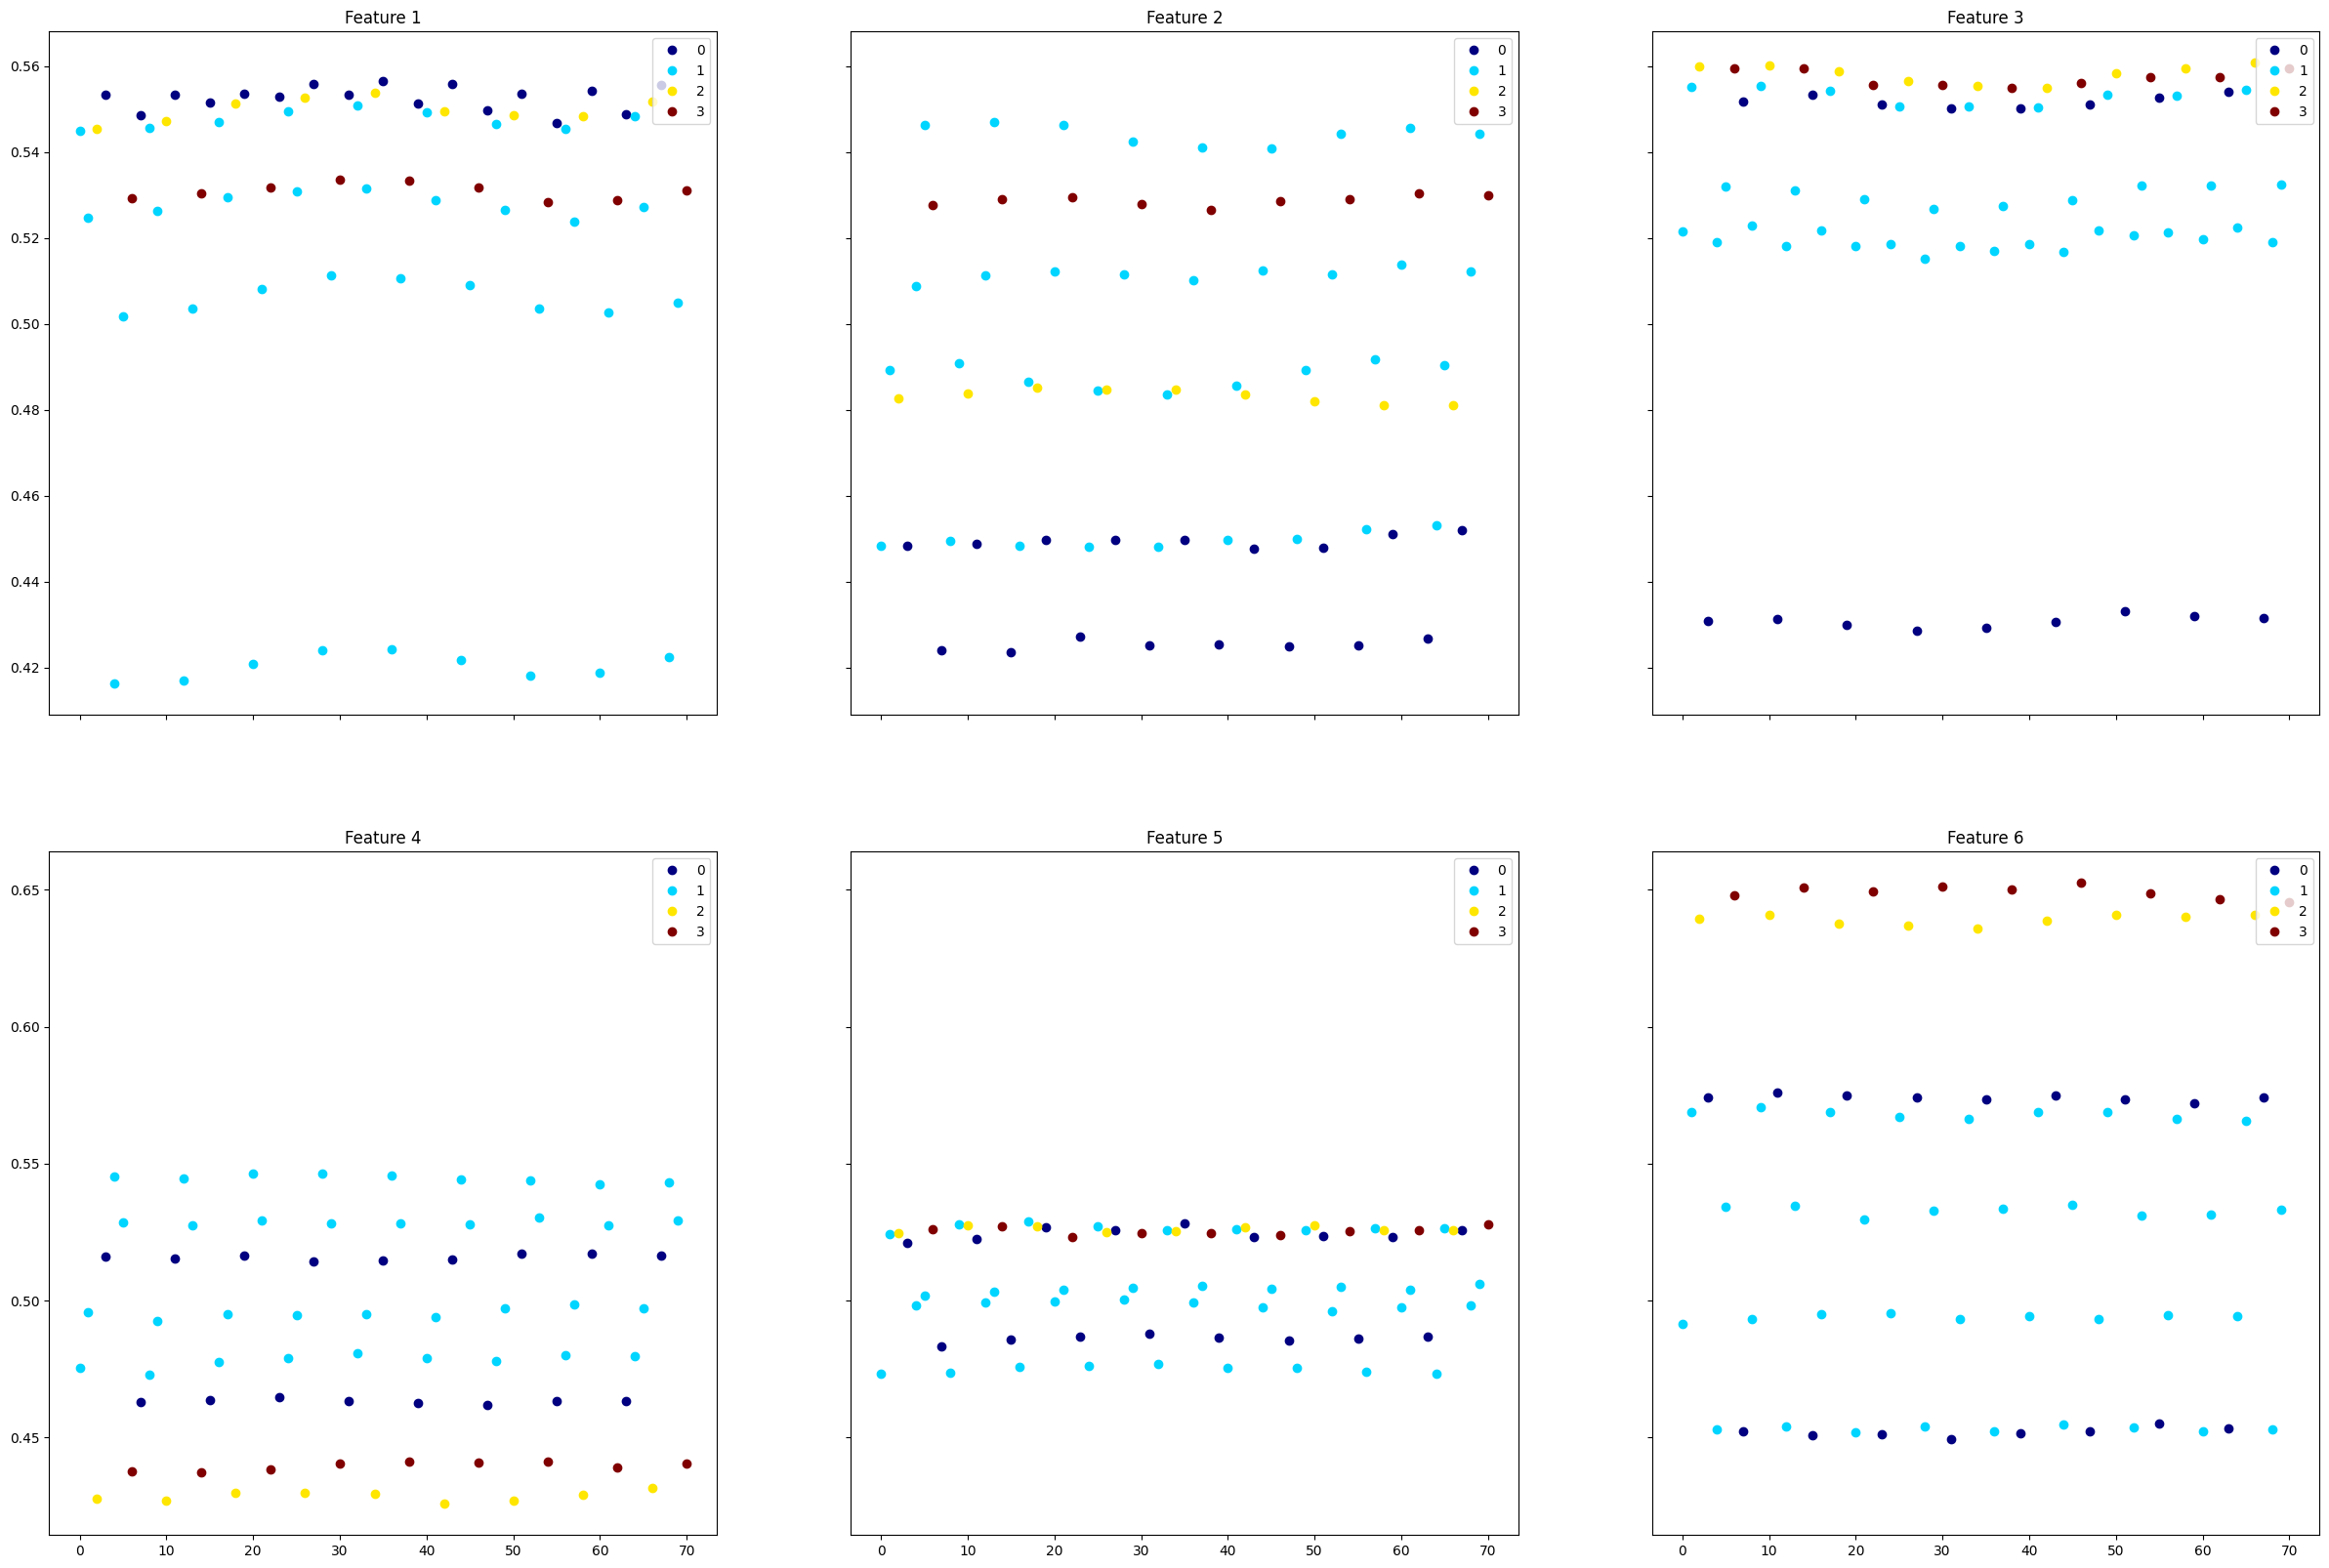

In [40]:
from qreservoirpy import state_plotter
fig, ax = state_plotter(xstates, target)

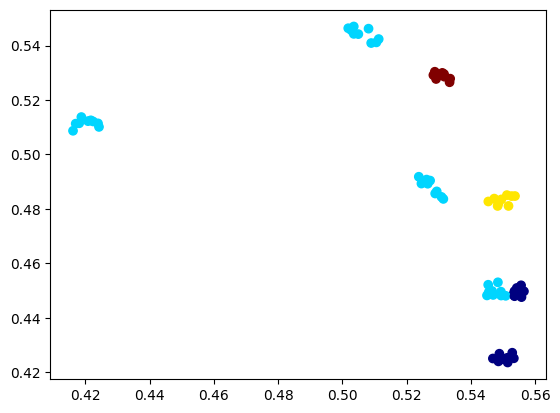

In [41]:
import matplotlib.pyplot as plt
import numpy as np
cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
plt.scatter(xstates[:, 0], xstates[:, 1], cmap=cmap, c=target)

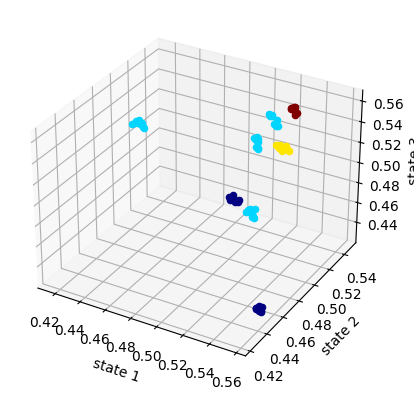

In [42]:
if xstates.shape[-1] >= 3:
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y, z in zip(target, xstates[:, 0], xstates[:, 1], xstates[:, 2]):
        ax.scatter(x, y, z, color=cmap(i))
    ax.set_xlabel('state 1')
    ax.set_ylabel('state 2')
    ax.set_zlabel('state 3')

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
num_pred = 20

model = KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(xstates, target, test_size=0.33, random_state=42)

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

model.fit(xstates, target)

1.0


KNeighborsClassifier(n_neighbors=1)

In [47]:
predictions = res.predict(
    num_pred=40,
    model=model,
    from_series=timeseries,
    shots=SHOTS
)

Predicting...: 100%|██████████| 40/40 [00:02<00:00, 15.55it/s]


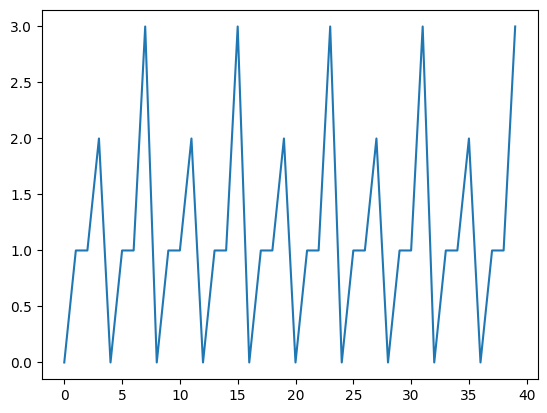

In [48]:
plt.plot(predictions)